<a href="https://colab.research.google.com/github/yk4r2/gradDesc/blob/master/Comparison_of_gradient_descents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В работе использовались открытые данные приложения к книге _An Introduction to Statistical Learning with Applications in R_ by _Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani_: [Туц](http://www-bcf.usc.edu/~gareth/ISL/data.html).

## Градиентный спуск
Параметры $w_0, w_1, w_2, w_3$, по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов будет выглядеть следующим образом:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}},\ j \in \{1,2,3\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

## Stochastic Gradient Descent (SGD)
Проблема градиентного спуска, описанного выше, в том, что на больших выборках считать на каждом шаге градиент по всем имеющимся данным может быть очень вычислительно сложно. 
В стохастическом варианте градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\},$$
где $k$ - случайный индекс, $k \in \{1, \ldots, \ell\}$.

In [0]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

**Загружаем информацию из файла advertising.csv**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
adver_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/advertising.csv')

adver_data.pop('N')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0        1
1        2
2        3
3        4
4        5
      ... 
195    196
196    197
197    198
198    199
199    200
Name: N, Length: 200, dtype: int64

**Смотрим на первые 5 записей и на статистику признаков в этом наборе данных.**

In [4]:
adver_data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


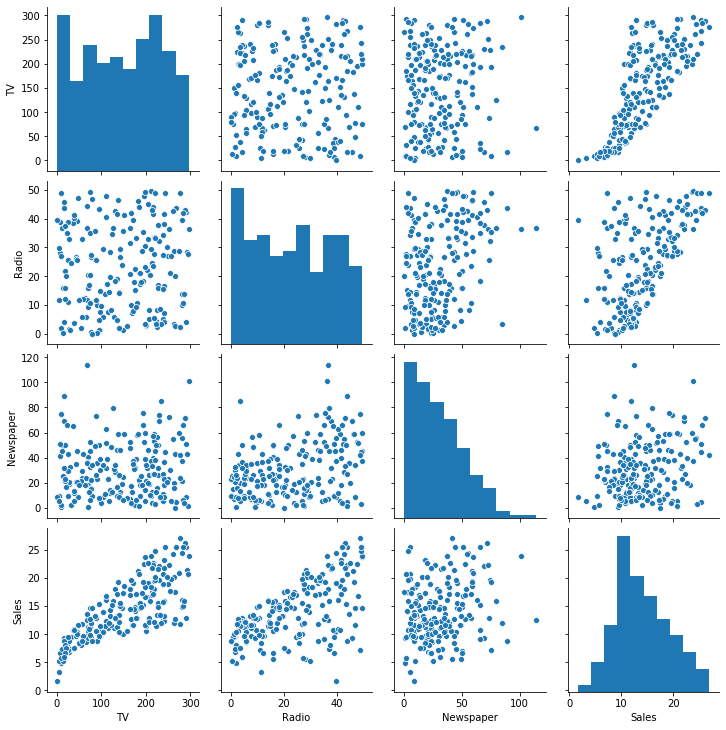

In [4]:
sns.pairplot(adver_data)

**Создаём массивы NumPy *X* из столбцов TV, Radio и Newspaper и *y* - из столбца Sales.**

In [0]:
X = adver_data[['TV', 'Radio', 'Newspaper']]
y = adver_data.Sales

**Масштабируем столбцы матрицы X, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение.**

In [0]:
# арифметическое среднее
means = X.apply(np.mean)

# стандартное отклонение
stds = X.apply(np.std)

In [0]:
X = X.apply(lambda x: (x - means) / stds, axis = 1)

In [8]:
X.apply(np.mean)
X.apply(np.std)

TV           1.0
Radio        1.0
Newspaper    1.0
dtype: float64

**Добавляем столбец из единиц, дабы не обрабатывать коэффициент линейной регрессии отдельно**

In [9]:
X['x0'] = 1
X = X[['x0', 'TV', 'Radio', 'Newspaper']]
X.head()

,x0,TV,Radio,Newspaper
0,1,0.969852,0.981522,1.778945
1,1,-1.197376,1.082808,0.669579
2,1,-1.516155,1.528463,1.783549
3,1,0.052050,1.217855,1.286405
4,1,0.394182,-0.841614,1.281802


**Реализуем функцию *mserror* - среднеквадратичную ошибку прогноза. Она принимает два аргумента - объекты Series *y* (значения целевого признака) и *y\_pred* (предсказанные значения).**

**Не используем в этой функции циклы - тогда она будет вычислительно неэффективной.**

Функция: $\dfrac{(y - y_{mean})^{2}}{n}$, где $n$ - количество координат вектора

In [0]:
def mserror(y, y_pred):
    return sum(list(map(lambda x1, x2: (x1 - x2) ** 2, y, y_pred))) / len(y)

**Написали функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.**

In [0]:
def linear_prediction(X, w):
    return X.apply(lambda x: np.dot(x, w), axis=1)

**Написали функцию *stochastic_gradient_step*, реализующую шаг стохастического градиентного спуска для линейной регрессии. Функция принимает матрицу *X*, вектора *y* и *w*, число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов, а также число *$\eta$* (eta) - шаг градиентного спуска (по умолчанию *eta*=0.01). Результат - вектор обновленных весов.**

Функция для шага:
$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$

In [0]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    l = len(y)
    x_k = X.values[train_ind]
    y_k = y.values[train_ind]
    
    return w - 2*eta/l*x_k*(np.dot(w, x_k) - y_k)

**Написали функцию *stochastic_gradient_descent*, реализующую стохастический градиентный спуск для линейной регрессии.
Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - максимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

**На каждой итерации в вектор (список) записывается текущее значение среднеквадратичной ошибки. Функция возвращает вектор весов $w$, а также вектор (список) ошибок.**

In [0]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        
        # обновление весов
        new_w = stochastic_gradient_step(X, y, w, random_ind, eta)
        
        iter_num+=1
        weight_dist = np.linalg.norm(new_w - w)
        
        errors.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    print(weight_dist)
    return w, errors

 **Запустили $10^5$ итераций стохастического градиентного спуска. Указали вектор начальных весов *w_init*, состоящий из нулей. Оставили параметры  *eta* и *seed* равными их значениям по умолчанию (*eta*=0.01, *seed*=42).**
 
 Запустили таймер.

In [14]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, np.zeros(4), max_iter = 2*1e4)
print(stoch_grad_desc_weights)

0.0013673647988632115
[12.10463763  3.39905381  2.33484676  0.34329643]
CPU times: user 5min 1s, sys: 2.57 s, total: 5min 3s
Wall time: 4min 59s


**Построили график ошибки на последних 50 итерациях стохастического градиентного спуска. Видим, что ошибка не обязательно уменьшается на каждой итерации.**

*MSE - mean square error

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

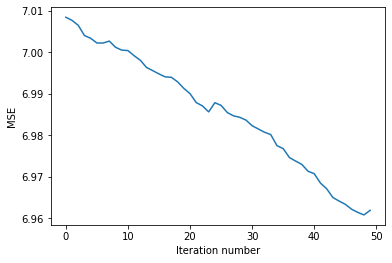

In [41]:
%pylab inline
plot(range(50), stoch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

**Построили график зависимости ошибки от номера итерации для $10^5$ итераций стохастического градиентного спуска. Видим, что алгоритм сходится.**

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

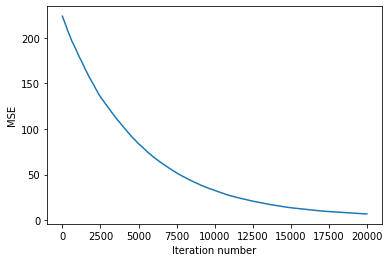

In [16]:
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# SGD with Momentum

In [0]:
def momentum_SGD_step(X, y, w, train_ind, v_pr, eta=0.01, beta=0.9):
    l = len(y)
    
    x_k = X.values[train_ind]
    y_k = y.values[train_ind]
    
    return w - 2*eta/l*x_k*(np.dot(w, x_k) - y_k) + beta * (v_pr)

In [0]:
def momentum_SGD(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False, beta=0.9):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_momentum_SGD = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
    v_pr = np.zeros(4)
    
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        # обновление весов
        new_w = momentum_SGD_step(X, y, w, random_ind, v_pr)
        v_pr = new_w - w
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        
        errors_momentum_SGD.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_momentum_SGD

In [19]:
%%time
momentum_SGD_weights, momentum_SGD_errors_by_iter = momentum_SGD(X, y, np.zeros(4), max_iter = 2*1e4, seed=42)
print('\n')
print(momentum_SGD_weights)



[13.94211547  3.93306826  2.78252436  0.04273565]
CPU times: user 4min 54s, sys: 753 ms, total: 4min 55s
Wall time: 4min 53s


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

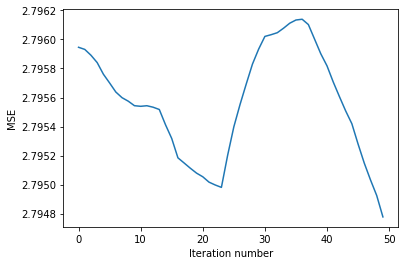

In [43]:
%pylab inline
plot(range(50), momentum_SGD_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

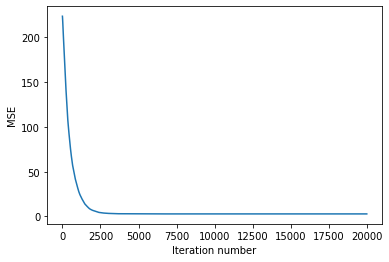

In [21]:
%pylab inline
plot(range(len(momentum_SGD_errors_by_iter)), momentum_SGD_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Цикличный mini-batch

In [0]:
def mini_batch_step(X, y, w, train_ind, random_ind, eta=0.01):
    l = len(y)
    x_k = [0.0] * train_ind
    y_k = [0.0] * train_ind
    
    for i in range(train_ind - 1):
        x_k[i] = X.values[random_ind[i]]
        y_k[i] = y.values[random_ind[i]]
    
    ans = 0
    for i in range(train_ind - 1):
        ans += 2*eta/l*x_k[i]*(y_k[i] - np.dot(w, x_k[i]))
    
    return w + ans

In [0]:
def mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = mini_batch_step(X, y, w, batch_size, random_ind)
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        
        errors_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_mini_batch

In [25]:
%%time
mini_batch_weights, mbatch_errors_by_iter = mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 2*1e4, batch_size = 10, seed=27)
print('\n')
print(mini_batch_weights)



[14.01640844  3.91502456  2.79097293 -0.03647065]
CPU times: user 5min 21s, sys: 3.44 s, total: 5min 25s
Wall time: 5min 18s


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

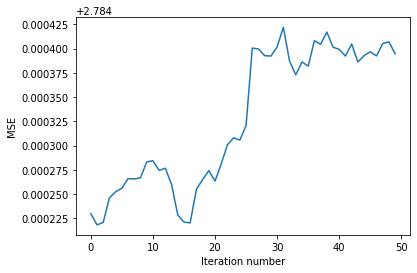

In [45]:
%pylab inline
plot(range(50), mbatch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

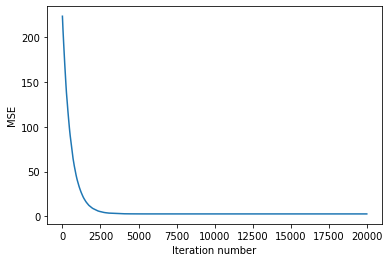

In [27]:
%pylab inline
plot(range(len(mbatch_errors_by_iter)), mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Mini-batch gradient descent

Попытка сделать через матрицы, а не через цикл

Функция для шага:
$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x^{T} \times (w^{T} \times x - y)^{T}}}$

In [0]:
def mini_batch_gradient_step(X, y, w, batch_size, train_ind, eta=0.01):
    l = len(y)

    i = 0
    x_k = np.zeros((batch_size, 4), dtype='float64')
    y_k = np.zeros(batch_size, dtype='float64')

    for i in range(batch_size - 1):
        x_k[i] = X.values[train_ind[i]]
        y_k[i] = y.values[train_ind[i]]

    return w + 2 * eta / l * np.dot(x_k.T, (y_k - np.dot(w.T, x_k.T).T))

In [0]:
def mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = mini_batch_gradient_step(X, y, w, batch_size, random_ind)
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        
        errors_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_mini_batch

In [30]:
%%time
mini_batch_weights, mbatch_errors_by_iter = mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 2*1e4, batch_size = 10, seed=27)
print('\n')
print(mini_batch_weights)



[14.01640844  3.91502456  2.79097293 -0.03647065]
CPU times: user 5min 6s, sys: 680 ms, total: 5min 7s
Wall time: 5min 6s


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

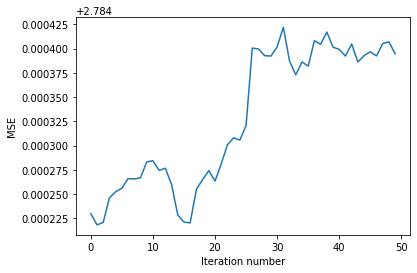

In [46]:
%pylab inline
plot(range(50), mbatch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

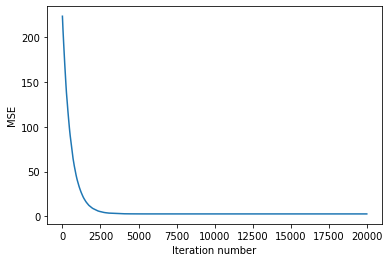

In [32]:
%pylab inline
plot(range(len(mbatch_errors_by_iter)), mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Mini-batch with Momentum

In [0]:
def momentum_mini_batch_gradient_step(X, y, w, batch_size, train_ind, v_pr, eta=0.01, beta=0.9):
    l = len(y)

    i = 0
    x_k = np.zeros((batch_size, 4), dtype='float64')
    y_k = np.zeros(batch_size, dtype='float64')

    for i in range(batch_size - 1):
        x_k[i] = X.values[train_ind[i]]
        y_k[i] = y.values[train_ind[i]]

    return w + 2 * eta / l * np.dot(x_k.T, (y_k - np.dot(w.T, x_k.T).T)) + beta * (v_pr)

In [0]:
def momentum_mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False, beta=0.9):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_momentum_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
    v_pr = 0
    
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = momentum_mini_batch_gradient_step(X, y, w, batch_size, random_ind, v_pr)
        v_pr = new_w - w
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        
        errors_momentum_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_momentum_mini_batch

In [36]:
%%time
momentum_mini_batch_weights, momentum_mbatch_errors_by_iter = momentum_mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 2*1e4, batch_size = 10, seed=27)
print(momentum_mini_batch_weights)

[14.03289174  3.89255618  2.78483663 -0.0915987 ]
CPU times: user 5min 9s, sys: 235 ms, total: 5min 9s
Wall time: 5min 9s


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

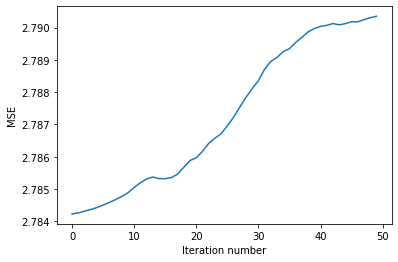

In [47]:
%pylab inline
plot(range(50), momentum_mbatch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

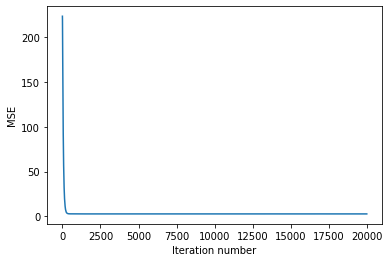

In [38]:
%pylab inline
plot(range(len(momentum_mbatch_errors_by_iter)), momentum_mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


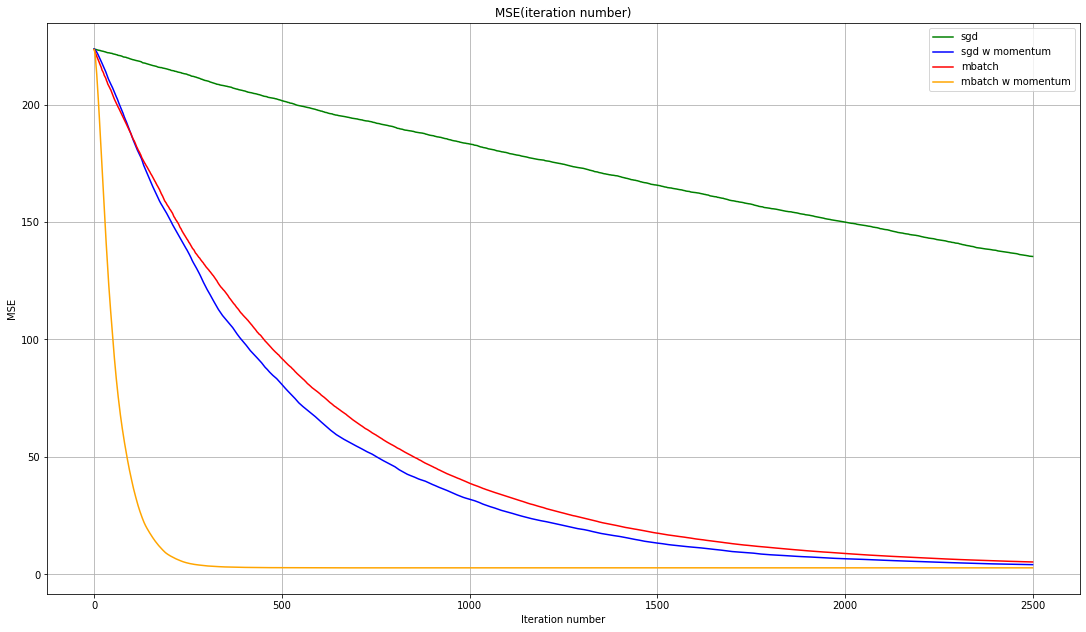

In [58]:
%pylab inline
plot(range(2500), stoch_errors_by_iter[:2500], label='sgd', color='green')
plot(range(2500), momentum_SGD_errors_by_iter[:2500], label='sgd w momentum', color='blue')
plot(range(2500), mbatch_errors_by_iter[:2500], label='mbatch', color='red')
plot(range(2500), momentum_mbatch_errors_by_iter[:2500], label='mbatch w momentum', color='orange')
xlabel('Iteration number')
ylabel('MSE')
plt.legend()

plt.grid()
plt.title('MSE(iteration number)')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('comparison_2.png', dpi=200)

Populating the interactive namespace from numpy and matplotlib


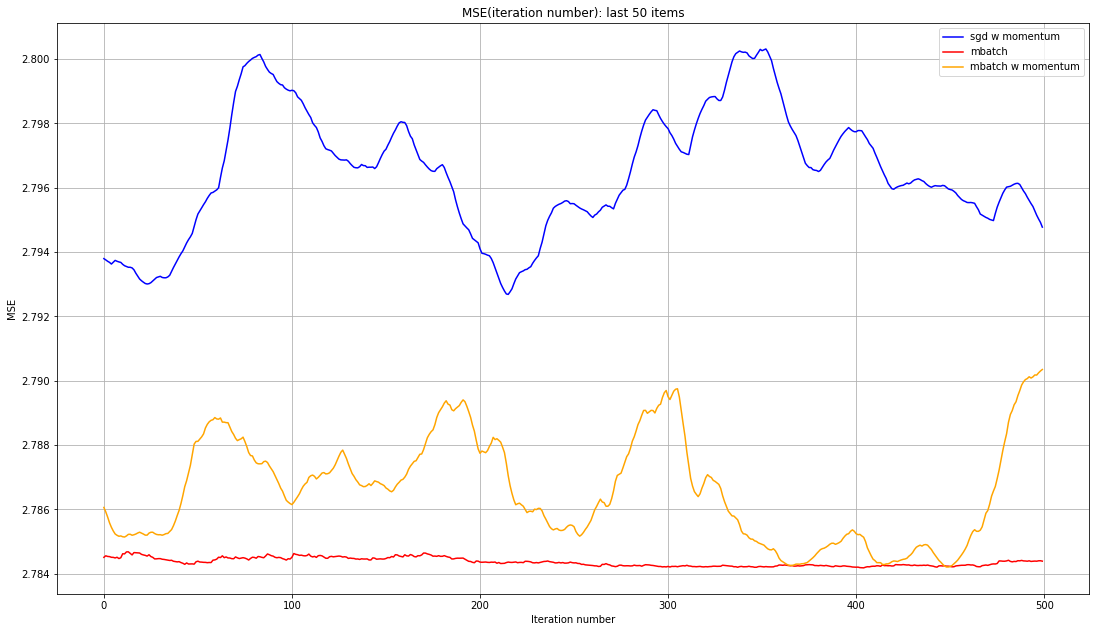

In [57]:
%pylab inline
plot(range(500), momentum_SGD_errors_by_iter[-500:], label='sgd w momentum', color='blue')
plot(range(500), mbatch_errors_by_iter[-500:], label='mbatch', color='red')
plot(range(500), momentum_mbatch_errors_by_iter[-500:], label='mbatch w momentum', color='orange')
xlabel('Iteration number')
ylabel('MSE')
plt.legend()

plt.grid()
plt.title('MSE(iteration number): last 50 items')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('comparison_2.png', dpi=200)